In [1]:
!python3 --version

Python 3.10.12


In [2]:
!pwd

/kaggle/working


In [3]:
!ls /kaggle/input/digit-recognizer

sample_submission.csv  test.csv  train.csv


# Packages

In [4]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import PIL
import os

np.random.seed(111)
random_state = 111

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
torch.cuda.get_device_name()

'Tesla T4'

# EDA & Preprocessing

In [7]:
path = "/kaggle/input/digit-recognizer"

train = pd.read_csv(os.path.join(path, "train.csv"))
test = pd.read_csv(os.path.join(path, "test.csv"))

In [8]:
train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


These are image matrices that have been transformed into unidimensional vectors, assuming they're square-shaped, we can reshape these arrays into $28 \times 28$ matrices ($\sqrt{784} = 28$).

In [10]:
dims = (28, 28)

example = train.values[0, 1:].reshape(dims)  # first column is the label field

example.shape

(28, 28)

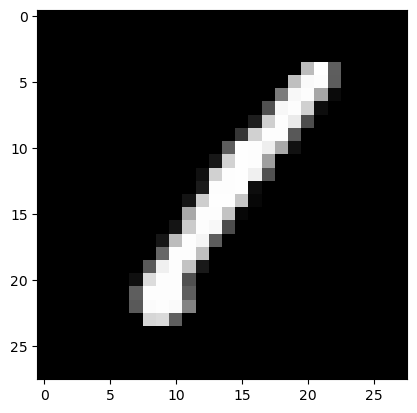

In [11]:
fig, ax = plt.subplots()

ax.imshow(example, cmap="gray")

fig.show()

We can select a few more images to show.  (Why not?).

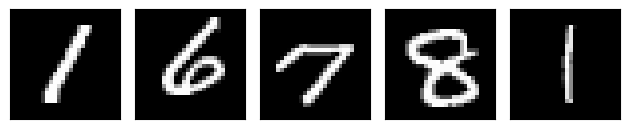

In [12]:
n_imgs = 5
imgs = []

for _ in range(n_imgs):
    img_idx = np.random.randint(0, len(train))
    imgs.append(train.values[img_idx, 1:].reshape(dims))

fig, axes = plt.subplots(ncols=n_imgs)
axes = axes.flatten()

for idx, ax in enumerate(axes):
    ax.imshow(imgs[idx], cmap="gray")
    ax.set_xticks([]); ax.set_yticks([])
    
fig.tight_layout()
fig.show()

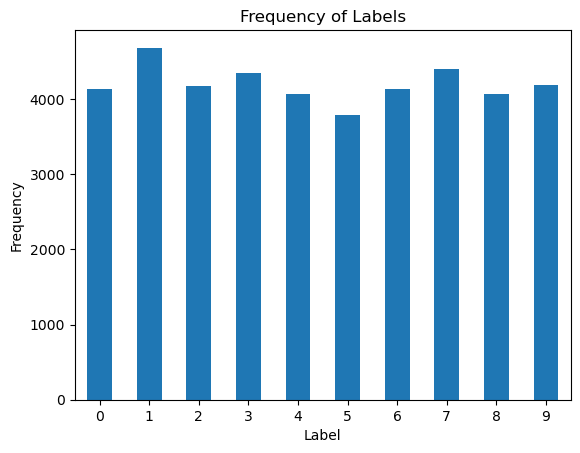

In [13]:
fig, ax = plt.subplots()

train.label.value_counts().sort_index().plot.bar(ax=ax, rot=0)

ax.set_title("Frequency of Labels")
ax.set_xlabel("Label"); ax.set_ylabel("Frequency")

fig.show()

In [14]:
def get_image_matrix(df: pd.DataFrame,
                     with_labels: bool = True,
                     dims: tuple[int] = (28, 28)) -> pd.DataFrame:
    """
    Receives a dataset of vectorized images and returns
    a dataset of the corresponding image matrices.
    """
    
    if with_labels:
        new_df = df[["label"]].copy(deep=True)
        new_df["img"] = df.iloc[:, 1:].apply(lambda row: row.values.reshape(dims), axis=1)
    else:
        new_df = pd.DataFrame(
            {"img": df.apply(lambda row: row.values.reshape(dims), axis=1)}
        )
    
    return new_df

In [15]:
df = get_image_matrix(train)

df.head(3)

,label,img
0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [16]:
get_image_matrix(test, with_labels=False).head(3)

,img
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


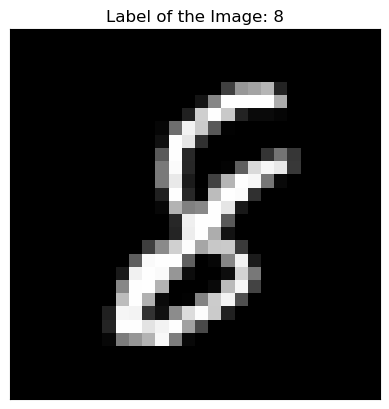

In [17]:
fig, ax = plt.subplots()

n_img = np.random.randint(0, len(df))
ax.imshow(df.img[n_img], cmap="gray")
ax.set_xticks([]); ax.set_yticks([])

ax.set_title(f"Label of the Image: {df.label[n_img]}")

fig.show()

In [18]:
class ImageDataset(Dataset):
    def __init__(self, raw_dataframe, with_labels=True, transform=get_image_matrix, normalized=False):
        self.raw_dataframe = raw_dataframe
        self.with_labels = with_labels
        self.dataframe = transform(self.raw_dataframe, with_labels=self.with_labels).values
        if with_labels:
            self.dataframe[:, 1:] = self.dataframe[:, 1:] / 255 if not normalized else self.dataframe[:, 1:]
        else:
            self.dataframe = self.dataframe / 255 if not normalized else self.dataframe
        
    def __getitem__(self, idx):
        if self.with_labels:
            img = torch.tensor(self.dataframe[idx, 1], dtype=torch.float32, device=device)
            label = torch.tensor(self.dataframe[idx, 0], dtype=torch.int64, device=device)
            return img, label
        else:
            img = torch.tensor(self.dataframe[idx, 0], dtype=torch.float32, device=device)
            return img
    
    def __len__(self):
        return len(self.dataframe)

In [19]:
train, val = train_test_split(train, test_size=0.8, random_state=random_state)

In [20]:
train_data = ImageDataset(train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

val_data = ImageDataset(val)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

test_data = ImageDataset(test, with_labels=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [21]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
#         self.fc = nn.Linear(64 * 24 * 24, 10)
        
#     def forward(self, x):
#         x = x.unsqueeze(1)  # add channel dimension
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = x.view(x.size(0), -1)  # reshape
#         x = self.fc(x)
#         return x

# Model

In [22]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.7):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc = nn.Sequential(
            nn.Linear(1152, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [23]:
cnn = CNN().to(device)

In [24]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.003)

for epoch in range(1, 16):
    cnn.train()
    epoch_train_loss = 0
    epoch_train_acc = 0
    
    for imgs, labels in train_loader:
        optimizer.zero_grad()
        
        preds = cnn(imgs)
        
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        epoch_train_acc += torch.mean((torch.argmax(preds, 1) == labels).type(torch.float32)).item()
    
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_acc = epoch_train_acc / len(train_loader)
    
    
    cnn.eval()
    epoch_val_loss = 0
    epoch_val_acc = 0
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            preds = cnn(imgs)
            loss = criterion(preds, labels)

            epoch_val_loss += loss.item()
            epoch_val_acc += torch.mean((torch.argmax(preds, 1) == labels).type(torch.float32)).item()
    
    epoch_val_loss = epoch_val_loss / len(val_loader)
    epoch_val_acc = epoch_val_acc / len(val_loader)
    
    print(f"Epoch {epoch}:",
          f"Train Loss: {epoch_train_loss:.4f} | Train Accuracy: {epoch_train_acc:.4f}",
          f"Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {epoch_val_acc:.4f}",
          sep="\n",
          end="\n\n")

Epoch 1:
Train Loss: 0.3566 | Train Accuracy: 0.8852
Val Loss: 0.0986 | Val Accuracy: 0.9709

Epoch 2:
Train Loss: 0.1419 | Train Accuracy: 0.9571
Val Loss: 0.0994 | Val Accuracy: 0.9715

Epoch 3:
Train Loss: 0.1145 | Train Accuracy: 0.9664
Val Loss: 0.0700 | Val Accuracy: 0.9801

Epoch 4:
Train Loss: 0.0894 | Train Accuracy: 0.9727
Val Loss: 0.0815 | Val Accuracy: 0.9784

Epoch 5:
Train Loss: 0.0636 | Train Accuracy: 0.9809
Val Loss: 0.0811 | Val Accuracy: 0.9786

Epoch 6:
Train Loss: 0.0536 | Train Accuracy: 0.9832
Val Loss: 0.0771 | Val Accuracy: 0.9813

Epoch 7:
Train Loss: 0.0439 | Train Accuracy: 0.9875
Val Loss: 0.0637 | Val Accuracy: 0.9838

Epoch 8:
Train Loss: 0.0432 | Train Accuracy: 0.9875
Val Loss: 0.1079 | Val Accuracy: 0.9733

Epoch 9:
Train Loss: 0.0398 | Train Accuracy: 0.9871
Val Loss: 0.0712 | Val Accuracy: 0.9846

Epoch 10:
Train Loss: 0.0297 | Train Accuracy: 0.9918
Val Loss: 0.0752 | Val Accuracy: 0.9843

Epoch 11:
Train Loss: 0.0281 | Train Accuracy: 0.9916
Val L

In [25]:
torch.save(cnn.state_dict(), "/kaggle/working/cnn.pt")

In [26]:
cnn.eval()

preds = []

for i in range(len(test_data)):
    pred = torch.argmax(cnn(test_data[i].unsqueeze(0))).item()
    preds.append(pred)

In [27]:
submission = pd.DataFrame(
    {"ImageId": list(range(1, len(test_data) + 1)), "Label": preds}
)

In [28]:
submission.to_csv("/kaggle/working/submission.csv", index=False)